# General Analysis

### Index:
* Train, Validation, Test split
* Train set descriptive analysis
    * Target variable histogram
    * Standar deviation histogram
    * Scatterplot between target and the standar deviation
    * Hardest and Easiest excerpt
* Benchmark Model
    * The flesch ease test
    * Scatterplot between FRE test and Target
    * Linear regression between FRE test and Target
    * Benchmark Performance metrics
* Final Thoughts

In [1]:
# for data management:
import numpy as np
import pandas as pd

# for plots:
import matplotlib.pyplot as plt
import seaborn as sns

# text stats
import textstat

# ML power
from sklearn import preprocessing

# python3 built-ins
from collections import defaultdict
import math

In [2]:
# Pandas settings for nice looking dataframes.
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

<ipython-input-2-e96aa488f3db>:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


## Divide dataset into train and test

#### First we need to divide our dataset into train and test, since the dataset is very small we will have 80% for training, 10% for validation and 10% for testing

In [3]:
data = pd.read_csv('data.csv')

# this is a non-sense point I have found in the data, erasing it:
data = data[(data['target']!=0) & (data['standard_error']!=0)]

# saving the train dataset (80%)
train = data.sample(frac=0.90, random_state=24)
train.to_csv('train.csv')

# test rows are the ones that are not in train dataframe.
train_ids = train.id.values
validation_and_test = data[~data['id'].isin(train_ids)]

# validation set will have 10% of the data
validation_set = validation_and_test.sample(frac=0.50, random_state=24)
validation_set.to_csv('validation.csv')

validation_ids = validation_set.id.values
test = validation_and_test[~validation_and_test['id'].isin(validation_ids)]

test.to_csv('test.csv')

In [4]:
# Just checking the totals still match:
assert len(data) == len(train)+len(validation_set)+len(test)

## Training data Descriptive analysis

#### Now let's inspect the train dataset to get a better understanding of the problem

In [5]:
# showing one training example
train.head(1)

,id,url_legal,license,excerpt,target,standard_error
339,62e7568a4,https://en.wikipedia.org/wiki/Earthquake,CC BY-SA 3.0,"An earthquake (also known as a quake, tremor or temblor) is the perceptible shaking of the surface of the Earth, resulting from the sudden release of energy in the Earth's crust that creates seismic waves. Earthquakes can be violent enough to toss people around and destroy whole cities. The seismicity or seismic activity of an area refers to the frequency, type and size of earthquakes experienced over a period of time.\nEarthquakes are measured using observations from seismometers. The moment magnitude is the most common scale on which earthquakes larger than approximately 5 are reported for the entire globe. The more numerous earthquakes smaller than magnitude 5 reported by national seismological observatories are measured mostly on the local magnitude scale, also referred to as the Richter magnitude scale. These two scales are numerically similar over their range of validity. Magnitude 3 or lower earthquakes are mostly imperceptible or weak and magnitude 7 and over potentially cause serious damage over larger areas, depending on their depth.",-0.403295,0.476486


In [6]:
train.describe()

,target,standard_error
count,2550.000000,2550.000000
mean,-0.966915,0.491388
std,1.031885,0.033583
min,-3.676268,0.428233
25%,-1.696522,0.468479
50%,-0.925342,0.484465
75%,-0.214269,0.505734
max,1.711390,0.649671


##### We can see the target variable is always between -3.6 and 1.7, let's create a histogram to check the distribution

<AxesSubplot:xlabel='target', ylabel='Count'>

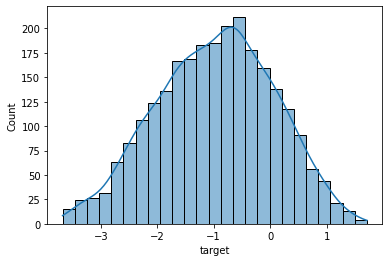

In [7]:
sns.histplot(train, x='target', kde=True)

##### We can see the target variable follows a bell-shaped distribution, similar to the normal distribution. Centered around -1.

<AxesSubplot:xlabel='standard_error', ylabel='Count'>

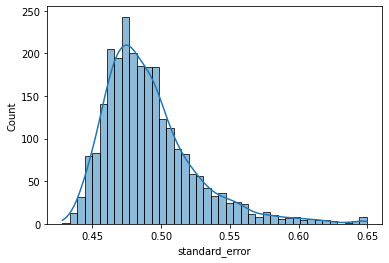

In [8]:
sns.histplot(train, x='standard_error', kde=True)

##### We can see the standar deviation of the target distribution is more like a chi-square distribution. it have a positive skewness.

##### Let's look this standard error compared to the target:

<AxesSubplot:xlabel='target', ylabel='standard_error'>

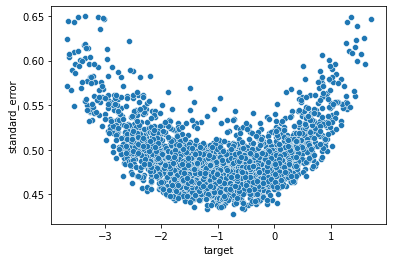

In [9]:
sns.scatterplot(data=train, x="target", y="standard_error")

##### We can see that the easier (or harder) the problem is, the bigger the standar error.

##### This means that "average" complexity excerpt were the ones with more agreement between assesors. and the harder ones are also the ones where more variation was introduced.

### This is the hardest excerpt in training data:

In [10]:
train.sort_values('target')['excerpt'].iloc[0]

'The commutator is peculiar, consisting of only three segments of a copper ring, while in the simplest of other continuous current generators several times that number exist, and frequently 120! segments are to be found. These three segments are made so as to be removable in a moment for cleaning or replacement. They are mounted upon a metal support, and are surrounded on all sides by a free air space, and cannot, therefore, lose their insulated condition. This feature of air insulation is peculiar to this system, and is very important as a factor in the durability of the commutator. Besides this, the commutator is sustained by supports carried in flanges upon the shaft, which flanges, as an additional safeguard, are coated all over with hard rubber, one of the finest known insulators. It may be stated, without fear of contradiction, that no other commutator made is so thoroughly insulated and protected. The three commutator segments virtually constitute a single copper ring, mounted i

### This is the easiest excerpt in training data:

In [11]:
train.sort_values('target')['excerpt'].iloc[-1]

'When you think of dinosaurs and where they lived, what do you picture? Do you see hot, steamy swamps, thick jungles, or sunny plains? Dinosaurs lived in those places, yes. But did you know that some dinosaurs lived in the cold and the darkness near the North and South Poles?\nThis surprised scientists, too. Paleontologists used to believe that dinosaurs lived only in the warmest parts of the world. They thought that dinosaurs could only have lived in places where turtles, crocodiles, and snakes live today. Later, these dinosaur scientists began finding bones in surprising places.\nOne of those surprising fossil beds is a place called Dinosaur Cove, Australia. One hundred million years ago, Australia was connected to Antarctica. Both continents were located near the South Pole. Today, paleontologists dig dinosaur fossils out of the ground. They think about what those ancient bones must mean.'

##### They both make sense, is difficult to explain text complexity but if you read both you can easily tell that one is harder than the other... nonetheless is difficult to narrow down excactly why.

## Benchmark model

##### This is the model I want to beat, its basically a linear regression between the target variable and the more commonly used complexity index (the flesch_reading_ease test)

### The Flesch readability test

The Flesch readability tests (FRE from now on) is a readability tests designed to indicate how difficult a passage in English is to understand. it uses both word length and sentence length for the calculation as you can see bellow:

<img src=https://wikimedia.org/api/rest_v1/media/math/render/svg/bd4916e193d2f96fa3b74ee258aaa6fe242e110e>

The FRE test goes from 0 to 100 and the bigger the number, the easier is to read the text
Since this is the most used way of measuring text complexity, I believe it will stand as a good benchmark for the problem.

##### for More info: https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests


### TextStats library helps create the FRE test without problems:

In [12]:
# flesch_reading_ease test calculated using textstat library
train['fre_test'] = train['excerpt'].apply(lambda value: textstat.flesch_reading_ease(value))

# standarizing between 0 an 1:
FRE_MIN = train['fre_test'].min()
FRE_MAX = train['fre_test'].max()

train['fre_test'] = (train['fre_test'] - FRE_MIN)/(FRE_MAX - FRE_MIN)

##### Please note that no pre-procesing is necesarry in order to use the textstats library, if you want to use it simply input the text as it is.

##### Let's plot the fre_test agains the target:

<AxesSubplot:xlabel='fre_test', ylabel='target'>

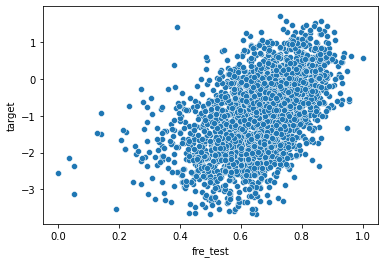

In [13]:
sns.scatterplot(data=train, x="fre_test", y="target")

#### There is some trend in the data, but is not really that much strong. Please notice that the bigger the FRE test is, larger the target is as well, this makes total sense.
#### Let's try to create a linear model out of it:

### Training Benchmark model

In [14]:
from sklearn.linear_model import LinearRegression

# storing training data in X and Y variables:
Y = train['target'].values
X = train['fre_test'].values.reshape(-1, 1)

# Fitting the model:
linreg = LinearRegression()
linreg.fit(X, Y)

LinearRegression()

#### Visual representation of this regression model in the training set:

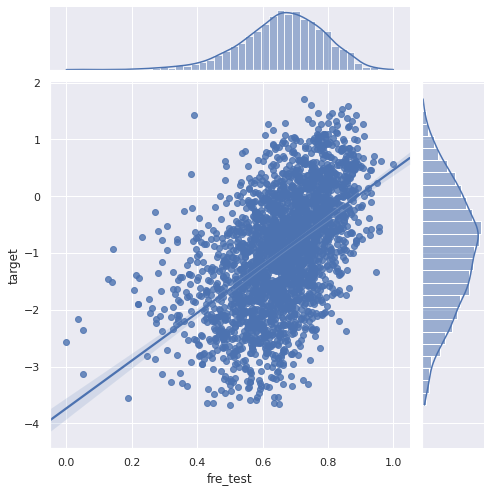

In [15]:
import seaborn as sns
sns.set_theme(style="darkgrid")

g = sns.jointplot(x="fre_test", y="target", data=train,
                  kind="reg", truncate=False, height=7)

### Bellow are the metrics that I wan't to beat:

##### Lets create the FRE test for the training set

In [16]:
# First creating the FRE test for the training set:
test['fre_test'] = test['excerpt'].apply(lambda value: textstat.flesch_reading_ease(value))
# standarizing by same metrics as in the training set:
test['fre_test'] = (test['fre_test'] - FRE_MIN)/(FRE_MAX - FRE_MIN)

<ipython-input-16-a087457a3274>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['fre_test'] = test['excerpt'].apply(lambda value: textstat.flesch_reading_ease(value))
<ipython-input-16-a087457a3274>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['fre_test'] = (test['fre_test'] - FRE_MIN)/(FRE_MAX - FRE_MIN)


#### Benchmark model performance metrics

In [17]:
# Finally calculating the benchmark metrics on the training set:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# calculating R2 for test set:
Y_test = test['target'].values
X_test = test['fre_test'].values.reshape(-1, 1)
X_test_pred = linreg.predict(X_test)

# R2:
print(f'test set R2: {round(linreg.score(X_test, Y_test), 6)}')
# MAE:
print(f'test set mae: {round(mean_absolute_error(Y_test, X_test_pred), 6)}')
# RMSE:
print(f'test set rmse: {round(math.sqrt(mean_squared_error(Y_test, X_test_pred)), 6)}')

test set R2: 0.188189
test set mae: 0.767187
test set rmse: 0.966072


#### Note: all this metrics were calculated on the test set, please bear those numbers in mind

### Final Thoughts

##### The metrics of the bechmark model are really not good, the R2 close 0 is a clear indication that the relationship is not lineal. 
##### Also a MAE of 0.77 for a variable that goes from -3.6 and 1.7 is a lot!
##### The same for our definitive our final metric, the RMSE is quite high.